# Beta tests

In [1]:
#!pip install colorednoise
#!pip install optuna

import colorednoise as cn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
import matplotlib.ticker as mtick
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import optuna
import seaborn as sns
from matplotlib.gridspec import GridSpec
import time
import datetime
import os 
import warnings
import numpy as np
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
warnings.filterwarnings('ignore')
np.random.seed(55)
torch.manual_seed(55)
sns.set_style("white")
pd.options.mode.chained_assignment = None  # default='warn'
%matplotlib inline

In [2]:
noise_names = ['White Noise','Pink Noise','Red Noise','Turbulence Noise']
colors = ['C0', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
colors_train_test = ['navy','purple'] 
color_noise = ['black','magenta','red','blue']
leters = ['(a)','(b)' ,'(d)' ,'(c)'  ,'(e)','(f)'  ,'(g)'   ,'(h)'    ,'(i)'  ,'(j)' ,'(k)' ,'(l)'  ,'(m)'   ,'(n)'  ,'(o)' ,'(p)'  ,'(q)']
leters_beta =  ['(a)','(b)','(d)','(c)' ]
romains = ['(I)','(II)','(III)','(IV)','(V)', '(VI)', '(VII)', '(VIII)', '(IX)', '(X)','(XI)','(XII)','(XIII)','(XIV)','(XV)','(XVI)','(XVII)']

In [3]:
def set_path(model='MLP',beta=0,user='usuario',met='ASNGNI',in_size=1024,out_size=2048):
    '''
    Change the path to save the results
    If you are not testing different metods, you will not need the `met` parameter
    This function will be used to save and load the results of the models especic
    for 1024 
    '''
    path = f'/home/{user}/Documentos/P1_RNN/Results/{met}/R_{model}_{in_size}_{out_size}_{beta}/'
    os.chdir(path)

class const(nn.Module):
    def __init__(self):
        super().__init__() # init the base class

    def forward(self, input):
        return input # simply apply already implemented SiLU

def create_dataset(dataset, window_in=10,window_ou=10,strid=1,isTensor=True):
  '''
  NORMALIZED DATASET BETEWENN -1 AND 1
  This function will contain two vectors, dataX and dataY, the dataX will contain a set of numbers within the time series
  and the dataY will be its posterior value
  For example:
  list = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
  if the window_in is equal to 3 anf window_ou equato to 2 we will have
  dataX[0] = [0,1,2] ; dataY[0] = [3,4]
  dataX[1] = [1,2,3] ; dataY[1] = [4,5]
  dataX[2] = [2,3,4] ; dataY[2] = [5,6]
  dataX[3] = [3,4,5] ; dataY[3] = [6,7]
  strid will, shift the data ex for 4:
  dataX[0] = [0,1,2] ; dataY[0] = [3,4]
  dataX[1] = [3,4,5] ; dataY[1] = [6,7]
  dataX[2] = [7,8,9] ; dataY[2] = [10,11]
  '''
  # This function must 
  dataset = dataset.reshape(len(dataset),1)
  dataset_train = dataset[:len(dataset)//2]
  dataset_test  = dataset[len(dataset)//2:]
  data_train_X, data_train_Y = [], []
  data_test_X, data_test_Y   = [], []

  for i in range(0,len(dataset_train)-window_in-window_ou+1,strid):
    _,data_norm = norm(dataset_train[i:i + window_in + window_ou])
    data_train_X.append(data_norm[0:(window_in)])
    data_train_Y.append(data_norm[ window_in:window_in + window_ou])
    #print(len(data_train_X[i]))

    _,data_norm = norm(dataset_test[i:i + window_in + window_ou])
    data_test_X.append(data_norm[0:(window_in)])
    data_test_Y.append(data_norm[window_in:window_in + window_ou])
    #print((data_train_X).astype(float))
  if isTensor:
    return torch.tensor(np.array(data_train_X)).float(), torch.tensor(np.array(data_train_Y)).float(),torch.tensor(np.array(data_test_X)).float(), torch.tensor(np.array(data_test_Y)).float()
  else:
    return np.array(data_train_X), np.array(data_train_Y),np.array(data_test_X), np.array(data_test_Y)

def create_dataset2(dataset, window_in=10,window_ou=10,strid=1,isTensor=True):
  '''
  NORMALIZED DATASET BETEWENN 0 AND 1
  This function will contain two vectors, dataX and dataY, the dataX will contain a set of numbers within the time series
  and the dataY will be its posterior value
  For example:
  list = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
  if the window_in is equal to 3 anf window_ou equato to 2 we will have
  dataX[0] = [0,1,2] ; dataY[0] = [3,4]
  dataX[1] = [1,2,3] ; dataY[1] = [4,5]
  dataX[2] = [2,3,4] ; dataY[2] = [5,6]
  strid will, shift the data ex for 4:
  dataX[0] = [0,1,2] ; dataY[0] = [3,4]
  dataX[1] = [3,4,5] ; dataY[1] = [6,7]
  dataX[2] = [7,8,9] ; dataY[2] = [10,11]
  '''
  # This function must 
  dataset = dataset.reshape(len(dataset),1)
  dataset_train = dataset[:len(dataset)//2]
  dataset_test  = dataset[len(dataset)//2:]
  data_train_X, data_train_Y = [] , []
  data_test_X , data_test_Y  = [] , []

  for i in range(0,len(dataset_train)-window_in-window_ou+1,strid):
    _,data_norm = norm2(dataset_train[i:i + window_in + window_ou])
    data_train_X.append(data_norm[0:(window_in)])
    data_train_Y.append(data_norm[ window_in:window_in + window_ou])
    #print(len(data_train_X[i]))

    _,data_norm = norm2(dataset_test[i:i + window_in + window_ou])
    data_test_X.append(data_norm[0:(window_in)])
    data_test_Y.append(data_norm[window_in:window_in + window_ou])
    #print((data_train_X).astype(float))
  if isTensor:
    return torch.tensor(np.array(data_train_X)).float(), torch.tensor(np.array(data_train_Y)).float(),torch.tensor(np.array(data_test_X)).float(), torch.tensor(np.array(data_test_Y)).float()
  else:
    return np.array(data_train_X), np.array(data_train_Y),np.array(data_test_X), np.array(data_test_Y)
def generate_data(size,win_in,win_ou,title='data.pt'):
  '''
  Create a Dataset in pytorch format and save it
  trainX[i] and trainY[i] are genereted from the same time serie 
  Normalized  between [-1,1].
  data[0] = whitenoise
  data[1] = pink noise
  data[2] = rednoise
  data[3] = Turbulence
  data[i][0] = trainX
  data[i][1] = trainY
  data[i][2] = train_testX
  data[i][3] = train_testY
  list = [0,1,2,3,4,5,6,7,8,9,10,11]
  if the window_in is equal to 3 anf window_ou equal to to 2 we will have
  dataX[0] = [0,1,2] ; dataY[0] = [3,4]
  dataX[1] = [1,2,3] ; dataY[1] = [4,5]
  dataX[2] = [2,3,4] ; dataY[2] = [5,6]
  strid will, shift the data ex for 4:
  dataX[0] = [0,1,2] ; dataY[0] = [3,4]
  dataX[1] = [3,4,5] ; dataY[1] = [6,7]
  dataX[2] = [7,8,9] ; dataY[2] = [10,11]
  '''
  data = [] #Empyty Vector
  betas = [0,1,2,5/3] #Values of Betas
  for i in range(len(betas)): #loop for alocate the tensot
    trainX, trainY          = dataset_test2(betas[i],size,win_in,win_ou)
    trainX_test,trainY_test = dataset_test2(betas[i],size,win_in,win_ou)
    
    data.append([trainX,trainY,trainX_test,trainY_test])
  torch.save(data, title) #Savig the file in .pt format
  return data

def skew(t):
    """
    Computes the skewness of a :class:`Tensor`. Note: this function uses cross-approximation (:func:`torchtorch.cross()`).
    :param t: a :class:`Tensor`
    :return: a scalar
    """
    return torch.mean(((t-torch.mean(t,dim=1)[:, None])/torch.std(t,dim=1)[:, None])**3,dim=1)

def kurtosis(t, fisher=True):
    """
    Computes the kurtosis of a :class:`Tensor`. Note: this function uses cross-approximation (:func:`torchtorch.cross()`).
    :param t: a :class:`Tensor`
    :param fisher: if True (default) Fisher's definition is used, otherwise Pearson's (aka excess)
    :return: a scalar
    """
    return torch.mean(((t-torch.mean(t,dim=1)[:, None])/torch.std(t,dim=1)[:, None])**4,dim=1) - fisher*3    

def param(data):
  '''
  Print the Statiscal momentun from a givin dataset
  '''
  data = torch.tensor(data)
  output={'kurtosis':kurtosis(data),
          'mean':    torch.mean(data,dim=1),
          'skew':    skew(data),
          'std':     torch.std(data,dim=1)}
  return output    

def param_2(data):
  '''
  Print the Statiscal momentun from a givin dataset
  '''
  #data = torch.tensor(data)
  output={'kurtosis':kurtosis(data),
          'mean':    torch.mean(data,dim=1),
          'skew':    skew(data),
          'std':     torch.std(data,dim=1)}
  return output    

def norm(data):
  '''
  Normalize the dataframe from -1 to 1
  '''
  scaler = MinMaxScaler((-1,1))
  data1 = np.reshape(data,(-1, 1))
  data1 = scaler.fit_transform(data1)
  data2 = np.reshape(data1,len(data1))
  return data1, data2


def norm2(data):
  '''
  Normaliza os dados entre 0 e 1
  '''
  scaler = MinMaxScaler()
  data1 = np.reshape(data,(-1, 1))
  data1 = scaler.fit_transform(data1)
  data2 = np.reshape(data1,len(data1))
  return data1, data2  

def norm4(data):
  '''
  Normaliza os dados entre 0 e 1
  but return vectors in a single shape
  '''
  #scaler = MinMaxScaler()
  scaler = MinMaxScaler((-1,1))
  data1 = np.reshape(data,(-1, 1))
  data1 = scaler.fit_transform(data1) 
  data2 = np.reshape(data1,len(data1))
  return data2  

# def norm5(data):
#     """
#     Normalize the input data between -1 and 1, while returning the vectors in a single shape
#     """
#     # Create the scaler object
#     scaler = MinMaxScaler((-1,1))

#     # Reshape the input data to have only one column
#     data1 = data.view(-1, 1).float()

#     # Normalize the data
#     data1 = scaler.fit_transform(data1)

#     # Reshape the normalized data back to a single vector
#     data2 = data1.view(-1)

#     return data2

def plot_psd(data,label='PSD',color='k',is_subplot = False,axis=None):
  '''
  This functions will show the PSD representation for any time series
  using the FFT of numpy library
  '''
  ft   = np.fft.fft(data)
  ft   = np.real(ft*np.conj(ft))
  freq = np.fft.fftfreq(len(ft))
  cond = (freq>0.0)
  ft,freq = ft[cond],freq[cond]  
  seq  = np.argsort(freq)
  
  a,b  = np.polyfit(np.log(freq[freq>0.0]),np.log(ft[freq>0.0]),deg=1)
  text = "{} {}f + {}".format(label,np.round(a,3),np.round(b,3))
  #plota o psd
  if is_subplot:
    return freq[seq],ft[seq], a,b 
  else:
    return plt.loglog(freq[seq],ft[seq],color=color,label=text)  

def plot_psd_batch(data,label=None,color='k',is_subplot = False,index=None):
  '''
  Will Return the PSD of a batch of time series using 
  the DBeta class
  '''
  #If type data is not a tensor, convert it
  if type(data) != torch.Tensor: data = torch.tensor(data)
  
  
  l = DBeta()
  if index == None: index = find_closest_to_mean(l.beta(data).detach().numpy()[:,0])
  psd, freq = l.psd(data) 
  beta = l.beta(data)
  if is_subplot:
    return freq, psd, beta 
  else:
    return plt.loglog(freq[index],psd[index],color=color,label=beta[index].detach().numpy()[0] if label == None else label) 


def plot_color_psd(data,n_cut=1,colors=['C9','C8','C7','C6','C5','C4','C3','C2','C1','C0']):
    '''
    Plot the PSD of a time series with different colors
    '''
    x = []
    ft = np.fft.fft(data)
    ft = np.real(ft*np.conj(ft))
    freq = np.fft.fftfreq(len(ft))
    seq = np.argsort(freq)
    freq = freq[seq]
    ft = ft[seq]

    df = pd.DataFrame()
    df.insert(0,'freq',freq)
    df.insert(1,'ft',ft)

    for i in range(n_cut): x.append(len(data)**(-(i+1)/n_cut))
    for i in reversed(range(n_cut)):
        plt.loglog(df['freq'][(df['freq'] >= x[i])],df['ft'][(df['freq'] >= x[i])])#,lw=1.0000001*n_cut-i)#,label=(i,x[i]))
        plt.axvline(x=x[i],color='gray',linestyle='--',label=(i,x[i]))
    #return df

def plot_test(x_,y_,color_x='C0',color_y='C1',linewidth=1,alpha=1):
  '''
  Plot two time series in sequence
  '''
  empty = np.empty_like(x_)
  empty[:] = np.nan
  y2 = np.append(empty,y_)
  plt.plot(x_,label='Input' ,color = color_x,linewidth=linewidth)
  plt.plot(y2,label='Target',color = color_y,linewidth=linewidth)


def create_dataframe(data_x,data_y,data_val_x=None,data_val_y =None,len_future=0):
    '''
     ########### CREATING DATAFRAME ###############
    #Create A inicial Dataframe with this size    
    #data_x = list(test_input_clone[0].detach().numpy().copy())
    #data_y = list(test_target_clone[0].detach().numpy().copy())
    '''
    l = DBeta()
    #Is data_y larger than data_x or vice-versa?
    if len(data_y) > len(data_x):  
      for index in range(len(data_y) - len(data_x)):  data_x.append(np.nan)
    elif len(data_x) > len(data_y):
      for index in range(len(data_x) - len(data_y)):  data_y.append(np.nan)
    #Is x and y smaller then the future predicts?
    if len_future > len(data_x):
      for index in range(len_future - len(data_x)): data_x.append(np.nan)
    if len_future > len(data_y):
      for index in range(len_future - len(data_y)): data_y.append(np.nan)
    #Create a Dataframe
    df = pd.DataFrame()
    df.insert(0,'trainX',data_x)
    df.insert(1,'trainY',data_y)
    df.insert(2,'input_GNI',np.random.rand(len(data_x)))
    
    if data_val_x is not None:
      ori_betas_x,ori_betas_y = [],[]
      #for i_1 in range(len(data_val_x)): ori_betas_x.append(plot_psd(norm4(data_val_x[i_1]),is_subplot=True)[2])
      #for i_2 in range(len(data_val_y)): ori_betas_y.append(plot_psd(norm4(data_val_y[i_2]),is_subplot=True)[2])

      for i_1 in range(len(data_val_x)):
          x = torch.tensor(np.resize(data_val_x[i_1],(1,data_val_x[i_1].shape[0])))
          ax = l.beta_mono(x).detach().numpy().item()
          ori_betas_x.append(ax) 
      for i_2 in range(len(data_val_y)):
          y = torch.tensor(np.resize(data_val_y[i_2],(1,data_val_y[i_2].shape[0])))
          ay = l.beta_mono(y).detach().numpy().item()
          ori_betas_y.append(ay)
      # y = torch.tensor(np.resize(data_val_y,(1,data_val_y.shape[0])))
      # ax = l.beta_mono(x).detach().numpy().item()
      # ay = l.beta_mono(y).detach().numpy().item()
      # for i_1 in range(len(data_val_x)): ori_betas_x.append(ax)
      # for i_2 in range(len(data_val_y)): ori_betas_y.append(ay)
      
      for index in range(len(data_x) - len(ori_betas_x)): ori_betas_x.append(np.nan)
      for index in range(len(data_x) - len(ori_betas_y)): ori_betas_y.append(np.nan)

      df.insert(3,'ori_betas_x',list(ori_betas_x))
      df.insert(4,'ori_betas_y',list(ori_betas_y))
    
    
    empty = np.empty_like(data_x)
    empty[:] = np.nan
    df.insert(len(df.columns),'loss_train',empty)
    df.insert(len(df.columns),'loss_valid',empty)
    df.insert(len(df.columns),'time',empty)
    
    return df


def append_dataframe(df,out,fut,out_betas,fut_betas,i):
  '''
  Function for append the new coluns in the traingloop
  '''
  out = list(out)
  fut = list(fut)
  out_betas = list(out_betas)
  fut_betas = list(fut_betas)
  len_data = len(df)
  #is the output smaller then the df numer of lines?  
  if len(out) < len_data:  
    for index_1 in range(len_data - len(out)):    out.append(np.nan)
  #is the output smaller then the df numer of lines?
  if len(fut) < len_data:  
    for index_2 in range(len_data - len(fut)):    fut.append(np.nan)
  #is the output smaller then the df numer of lines?
  if len(out_betas) < len_data:
    for index_3 in range(len_data - len(out_betas)):    out_betas.append(np.nan)
  #is the output smaller then the df numer of lines?
  if len(fut_betas) < len_data:
    for index_4 in range(len_data - len(fut_betas)):    fut_betas.append(np.nan)
  df.insert(len(df.columns),f'out{i+1}',out)
  df.insert(len(df.columns),f'fut{i+1}',fut)
  df.insert(len(df.columns),f'out_betas{i+1}',out_betas)
  df.insert(len(df.columns),f'fut_betas{i+1}',fut_betas)



# def plot_results(x,y,z,w,shift_1=0,epoch=0):
#   '''
#   One single function to plot all the results
#   '''
#   plt.figure(figsize=(15,6))
#   plt.suptitle(f'Results for Epoch {epoch+1}',  y=1.00, horizontalalignment='center', verticalalignment='bottom')#, fontsize = 15)
#   gs = GridSpec(1,2,width_ratios=[2,1])

#   plt.subplot(gs[0,0])
#   plt.title("Time Series")
#   plt.xlabel("x")
#   plt.ylabel("y")

#   shift_2 = len(x) + shift_1
#   shift_3 = len(y) + shift_2
#   plt.plot(np.arange(shift_1,shift_1+len(x)), x, color='C0',      linewidth=1.0,label='Input')            
#   plt.plot(np.arange(shift_2,shift_2+len(y)), y, color='C1',      label='Target')
#   plt.plot(np.arange(shift_2,shift_2+len(z)), z, color = 'brown', linewidth=1.0,label='Model Output')
#   plt.plot(np.arange(shift_3,shift_3+len(w)), w, color = 'green', linewidth=1.0,label='Future')
#   plt.axvline(shift_3,ls='--')
#   plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2),
#            ncol=4, fancybox=True, shadow=True)#,prop={'size': 15}) 

#   plt.subplot (gs[0,1])
#   plot_psd(z,'Expected','brown')
#   plot_psd(w,'Future','green')
#   plot_psd(y,'Output','C1')
#   plt.title('Power Spectrum Density')
#   plt.xlabel("f (Frequency)")
#   plt.ylabel("Energy (PSD)")
#   plt.tight_layout()
#   for k in range(n_cut): plt.axvline(x=(len(x)**(-(k+1)/n_cut)),color='r',ls='--')
#   plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3),
#            ncol=1, fancybox=True, shadow=True)#,prop={'size': 15}) 

#   #plt.savefig("predict%d.png"%i, dpi=200)
#   plt.show()
#   plt.close()


# def plot_results(y,z,w,ay,az,aw,size_x=10,size_y=10,model = None,title = None):
#   '''
#   One single function to plot all the results
#   '''
#   if model == None: model = ''
#   #fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(size_x,size_y))
#   fig.subplots_adjust(hspace=0.3)
#   #fig.suptitle(f'{title}',  y=1.00, horizontalalignment='center', verticalalignment='bottom')#, fontsize = 15)

#   #x, y, z, w , ay, by, az, bz, aw, bw, score = time_series(models[i], betas[j], 'usuario',gni,trials[i][j])        
#   # Original Signal
#   axs[0,0].plot(np.arange(len(y)), y, color = 'k',label='Target')
#   axs[0,0].set_ylabel(f'Test', fontsize = 15)

#   axs[0,1].loglog(ay[0],ay[1], color = 'k',label=ay[2])#,linewidth=linewidth)     
#   axs[0,1].legend()
#   axs[0,1].set_ylim(1e-4,1e5)
#   # Validation Signal
#   axs[1,0].plot(np.arange(len(z)), z, color = 'C0')
#   axs[1,0].set_title(f'$\\Delta \\beta_1$ = {az[2]-ay[2]:.5f}',y=0.99,x=1.1, horizontalalignment='center', verticalalignment='bottom', fontsize = 15)
  
#   axs[1,1].loglog(az[0],az[1], color = 'C0',label= "{} {}f + {}".format('PSD',np.round(az[2],3),np.round(az[3],3)))#,linewidth=linewidth)
#   axs[1,1].legend()
#   axs[1,1].set_ylim(1e-4,1e5)
#   # Free Signal
#   axs[2,0].plot(np.arange(len(w)), w, color = 'C1')
#   axs[2,0].set_title(f'$\\Delta \\beta_2$ = {az[2]-aw[2]:.5f}',y=0.99,x=1.1, horizontalalignment='center', verticalalignment='bottom', fontsize = 15)
  
#   axs[2,1].loglog(aw[0],aw[1], color = 'C1',label= "{} {}f + {}".format('PSD',np.round(aw[2],3),np.round(aw[3],3)))#,linewidth=linewidth)
#   axs[2,1].legend()
#   axs[2,1].set_ylim(1e-4,1e5)
#   axs[1,0].set_ylabel(f'{model}\n     Free                      Validation', y = -.1, fontsize = 15)
#   axs[1,1].legend()


# def plot_results2(y,z,w,ay,az,aw,ori_betas,out_betas,fut_betas,size_x=10,size_y=10,model_title = None,sup_title = None,beta=2):
#   '''
#   One single function to plot all the results
#   '''
#   models_color = ['black','magenta','red','blue']
#   if model_title == None: model_title = ''
#   #fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(size_x,size_y))
  
#   fig = plt.figure(figsize=(10,10))
#   gs = GridSpec(4, 2)

#   fig.suptitle(f'{sup_title}',  y=.90, horizontalalignment='center', verticalalignment='bottom')#, fontsize = 15)

#   # Original Signal
#   ax1 = fig.add_subplot(gs[0, 0])
#   ax1.plot(np.arange(len(y)), y, color = models_color[beta],label=f'{beta}')
#   ax1.set_ylabel(f'Test', fontsize = 15)
#   #ax1.legend()
  
#   ax2 = fig.add_subplot(gs[0, 1])
#   ax2.loglog(ay[0],ay[1], color = models_color[beta],label= "{} {}f + {}".format('PSD',np.round(ay[2],3),np.round(ay[3],3)))
#   ax2.legend()
#   ax2.set_ylim(1e-4,1e5)
  
#   # Validation Signal
#   ax3 = fig.add_subplot(gs[1, 0])
#   ax3.plot(np.arange(len(z)), z, color = 'C0')
#   #ax3.set_title(f'$\\Delta \\beta_1$ = {az[2]-ay[2]:.5f}',y=0.99,x=1.1, horizontalalignment='center', verticalalignment='bottom', fontsize = 15)
#   ax3.set_ylabel(f'{model_title}\n     Free                      Validation', y = -.1, fontsize = 15)

#   ax4 = fig.add_subplot(gs[1,1])
#   ax4.loglog(az[0],az[1], color = 'C0',label= "{} {}f + {}".format('PSD',np.round(az[2],3),np.round(az[3],3)))#,linewidth=linewidth)
#   ax4.legend()
#   ax4.set_ylim(1e-4,1e5)
#   ax4.legend()
#   # Free Signal
#   ax5 = fig.add_subplot(gs[2,0])
#   ax5.plot(np.arange(len(w)), w, color = 'C1')
#   #ax5.set_title(f'$\\Delta \\beta_2$ = {az[2]-aw[2]:.5f}',y=0.99,x=1.1, horizontalalignment='center', verticalalignment='bottom', fontsize = 15)
  
#   #Future prediction
#   ax6 = fig.add_subplot(gs[2, 1])
#   ax6.loglog(aw[0],aw[1], color = 'C1',label= "{} {}f + {}".format('PSD',np.round(aw[2],3),np.round(aw[3],3)))#,linewidth=linewidth)
#   ax6.legend()
#   ax6.set_ylim(1e-4,1e5)

#   beta_t, beta_v,  beta_o= round(np.mean(out_betas),4), round(np.mean(fut_betas),4),round(np.mean(ori_betas),4)
#   delta_beta_t = round(abs(np.mean(ori_betas)-np.mean(out_betas)),4)
#   delta_beta_v = round(abs(np.mean(ori_betas)-np.mean(fut_betas)),4)
      
#   ax7 = fig.add_subplot(gs[3, :])
#   #ax7.set_title(f'$\\beta$ = {beta}\n$\\Delta \\beta_t$ = {delta_beta_t} - $\\Delta \\beta_v$ = {delta_beta_v}\n{title}')
#   ax7.hist(out_betas,bins = 20,label = f'out {beta_t}')
#   ax7.hist(fut_betas,bins = 20,label = f'fut {beta_v}')
#   ax7.hist(ori_betas,bins = 20,label = f'ori {beta_o}' ,color= models_color[beta])
#   ax7.axvline(x=-beta,color='purple',label = f'beta {beta}')
#   ax7.axvline(x=beta_t,color='green',linestyle = '--')
#   ax7.axvline(x=beta_v,color='blue' ,linestyle = '--')
#   ax7.axvline(x=beta_o,color='gray',linestyle = '--')
#   ax7.set_ylabel('Frequency',fontsize = 15)
#   ax7.set_xlabel('$\\beta$',fontsize = 15)
#   ax7.legend(loc='lower center', bbox_to_anchor=(0.5, -0.4),ncol=4, fancybox=True, shadow=True)#,prop={'size': 15}) 

  
# def plot_results3(y,z,w,ay,az,aw,ori_betas,out_betas,fut_betas,size_x=10,size_y=10,model_title = None,sup_title = None,beta=2):
#   '''
#   One single function to plot all the results
#   '''
#   models_color = ['black','magenta','red','blue']
#   if model_title == None: model_title = ''
#   #fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(size_x,size_y))
  
#   import matplotlib.pyplot as plt
#   import numpy as np
#   from scipy.stats import gaussian_kde
#   '''
#   One single function to plot all the results
#   '''
#   models_color = ['black','magenta','red','blue']

#   #fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(size_x,size_y))
  
#   fig = plt.figure(figsize=(10,10))
#   gs = GridSpec(4, 2)

#   fig.suptitle(f'{sup_title}',  y=.90, horizontalalignment='center', verticalalignment='bottom')#, fontsize = 15)
#   #Trial = {trial}
#   # Original Signal
#   ax1 = fig.add_subplot(gs[0, 0])
#   ax1.plot(np.arange(len(y)), y, color = models_color[beta],label=f'{beta}')
#   ax1.set_ylabel(f'Test', fontsize = 15)
#   #ax1.legend()
  
#   ax2 = fig.add_subplot(gs[0, 1])
#   ax2.loglog(ay[0],ay[1], color = models_color[beta],label= "{} {}f + {}".format('PSD',np.round(ay[2],3),np.round(ay[3],3)))
#   ax2.legend()
#   ax2.set_ylim(1e-4,1e5)
  
#   # Validation Signal
#   ax3 = fig.add_subplot(gs[1, 0])
#   ax3.plot(np.arange(len(z)), z, color = 'C0')
#   ax3.set_ylabel(f'{model_title}\n     Free                      Validation', y = -.1, fontsize = 15)

#   ax4 = fig.add_subplot(gs[1,1])
#   ax4.loglog(az[0],az[1], color = 'C0',label= "{} {}f + {}".format('PSD',np.round(az[2],3),np.round(az[3],3)))#,linewidth=linewidth)
#   ax4.legend()
#   ax4.set_ylim(1e-4,1e5)
#   ax4.legend()
#   # Free Signal
#   ax5 = fig.add_subplot(gs[2,0])
#   ax5.plot(np.arange(len(w)), w, color = 'C1')
  
#   #Future prediction
#   ax6 = fig.add_subplot(gs[2, 1])
#   ax6.loglog(aw[0],aw[1], color = 'C1',label= "{} {}f + {}".format('PSD',np.round(aw[2],3),np.round(aw[3],3)))#,linewidth=linewidth)
#   ax6.legend()
#   ax6.set_ylim(1e-4,1e5)

#   beta_t, beta_v,  beta_o= round(np.mean(out_betas),4), round(np.mean(fut_betas),4),round(np.mean(ori_betas),4)
#   delta_beta_t = round(abs(np.mean(ori_betas)-np.mean(out_betas)),4)
#   delta_beta_v = round(abs(np.mean(ori_betas)-np.mean(fut_betas)),4)
      
#   ax7 = fig.add_subplot(gs[3, :])

#   df_plot = pd.DataFrame({'Test':ori_betas,'Validation':out_betas,'Future':fut_betas})
#   sns.violinplot(data=df_plot,palette=[models_color[beta],colors[0],colors[1]],cut=0,inner='quartile',scale='width',width=0.8,linewidth=1.5,ax=ax7)
#   beta_especial = '5/3'

#   ax7.set_xlabel(f'$\\Delta \\beta_t$ = {delta_beta_t} - $\\Delta \\beta_v$ = {delta_beta_v}')
#   ax7.set_ylabel('Violin Plot',fontsize = 15)
#   # if savefig == True: 
#   #   if fig_pdf == True:
#   #     os.chdir('/home/barauna/Documentos/P1_RNN/Results/')
#   #     fig.savefig(f'best_model_beta_{beta}.pdf',bbox_inches='tight',dpi=300)
#   #   else:
#   #     if not os.path.exists('figures'):  os.mkdir('figures')
#   #     fig.savefig('figures/Trial_{:03d}.png'.format(trial)) #Getting the 3 values 
#   # if showfig == True: plt.show()
#   # plt.close()  
  
  
#     #axs[2*i+1 ,0].set_ylabel(f'{models[i]}\nFree             Validation', y = -.1, fontsize = fontsize)

#def plot_results3(model = 'MLP',beta=0, trial = None,epoch = 10, user = 'barauna', met='ASNGNI', line_width = 1, sup_title = None,savefig=False,showfig=True,fig_pdf=True):


# def dt(t0,t1):
#   '''
#   Print Time Interval
#   '''
#   dt = t1-t0
#   if dt < 60:           dtf = str(round(dt,3))+' s'
#   elif 3600 > dt > 60:  dtf = str(round(dt/60,3))+' min'
#   elif dt > 3600:       dtf = str(round(dt/3600,3))+' hours'
#   return dtf  


# Clean Bad seteces
def clean_results(file_input, df_output = 'result.csv',best_model = True):
    '''
    The output files runing in a HPC extract a lot of warning.
    This warnings is provide by the randow choices that some times get nan values
    For this reason the output.txt file need do be clean to be analysed
    #######
    This code extract usefull information for the original output file and print the value of the best trial case
    If the output file come with new 'bad sentences' fell free do fill the `bad_sentence` vector with tham
    '''
    file_output = 'CLEAR_'+file_input
    #Extract the Best trial result
    with open(file_input, "r") as file: 
        lines = file.readlines()
        last_line = lines[-2] #
    result = last_line[12:200]
    #Print the Best trial value
    for i in range(len(lines)-2):
        if lines[i].find(result) != -1: index = i
    best_trial = lines[index][37:46]
    #https://stackoverflow.com/questions/11968998/read-lines-from-one-file-and-write-to-another-file-but-remove-lines-that-contain
    bad_sentences = ["/home/barauna/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:461: RuntimeWarning: All-NaN slice encountered",
                "/home/barauna/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:462: RuntimeWarning: All-NaN slice encountered",
                "  data_min = np.nanmin(X, axis=0)",
                "/home/barauna/anaconda3/lib/python3.9/site-packages/optuna/study/study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.",
                "  warnings.warn(",
                "[32m[I 2022-12-09 15:47:21,401] [0m A new study created in memory with name: no-name-4c3905de-7efe-42f5-8327-c1e279438960[0m",
                "  data_max = np.nanmax(X, axis=0)",
                "failed",
                "A new study created in memory with name",
                "Number of finished trials",
                "/home/luan/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:46",
                "Email Sent"]
    with open(file_input) as oldfile, open(file_output, 'w') as newfile:
        for line in oldfile:
            if not any(bad_sentences in line for bad_sentences in bad_sentences):
                newfile.write(line)
                 
    f = open(file_output)
    lines = f.readlines()
    f.close()
    f = open(file_output, 'w')
    for line in lines:
        f.write(line[37:].split("}", 1)[0]+"}\n")
    f.close()

    dic = {}
    dfs = []
    #Create a list of dictionaries
    for i in range(len(lines)-1):
        dic.update({'Trial':lines[i].split('Trial ')[1].split(' finished')[0]})
        dic.update({'Score':lines[i].split('value: ')[1].split(' and parameters')[0]})
        a = lines[i].split('{')[1].split('}')[0].split(', ')
        for j in range(len(a)):
            b = a[j].split(': ')
            dic.update({str(b[0][1:-1]):b[1]})
        #Apeend the dictionary to a list of dictionaries into a dataframe    
        dfs.append(pd.DataFrame(dic, index=[0]))
    #Concatenate the list of dataframes into a dataframe
    df = pd.concat(dfs)    
    #Change the type of the columns
    df['Trial'] = df['Trial'].astype(int)
    df = df.sort_values(by=['Trial'])
    df['Score'] = df['Score'].astype(float)
    df['n_layers'] = df['n_layers'].astype(int)
    df['n_cut'] = df['n_cut'].astype(int)
    for i in range(max(df['n_layers'])):
        df['hidden_layers'+str(i)] = df['hidden_layers'+str(i)].astype(float)
        df['dropout'+str(i)] = df['dropout'+str(i)].astype(float)
    
    if best_model: print(df.iloc[df['Score'].idxmin()])
    return df.to_csv(df_output, index=False)

def plot_summary(df):
    plt.subplot(2,2,1)
    plt.title('Optimiser')
    sns.histplot(df['optimiser'])

    plt.subplot(2,2,2)
    plt.title('Number of layers')
    sns.histplot(df['n_layers'].astype(str))

    plt.subplot(2,2,3)
    plt.title('Neurons per layer')
    for i in range(1,max(df['n_layers'])+1): 
        plt.plot(df['hidden_layers'+str(i)].values,label=f'Layer {i}')
    plt.legend()

    plt.subplot(2,2,4)
    plt.title('Dropout')
    for i in range(1,max(df['n_layers'])+1): 
        plt.plot(df['dropout'+str(i)].values)

def report(CODE_NAME,CPU=None):
  # Creating the respective object along with the gmail login and port number
  from smtplib import SMTP
  import socket
  if CPU: 
     pass
  else: CPU = str(socket.gethostname())

  email_mine  = "fismatcom.py1@gmail.com"
  password_mine  = "kuwfpepwzukdydwd"
  email1 = "luanorion@hotmail.com"
  #email2 = "luanorion1@gmail.com"
  CODE_NAME = str(CODE_NAME)

  smtp_port = SMTP("smtp.gmail.com", 587)# Establishing a connection to the SMTP server with Transport Layer Security (TLS) mode
  smtp_port.ehlo()# Informing the client to establish a secure connection, either to a TLS or SSL
  smtp_port.starttls()# Logging into your account
  smtp_port.login(email_mine , password_mine)
  final_message = f"Subject: {subject} \n \n {body}"

  # Creating the list of email addresses
  address_list = [email1]#, email2]
  smtp_port.sendmail(email_mine, address_list, final_message)
  print("Email Sent")
  smtp_port.quit() 
  

  
def plot_loss(train,valid,title='Loss Metrics'):
  '''
  Plot Loss metrics
  '''
  plt.figure(figsize=(15,6))
  plt.title(title)
  plt.plot(train,label='Train')
  plt.plot(valid,label='Validation')
  plt.xlabel('Epochs')
  plt.ylabel('Score')
  plt.legend()
  
  
def find_closest_to_mean(arr):
    
    if type(arr) == torch.Tensor: 
      arr = arr.detach().numpy()

    
    mean_value = np.mean(arr)
    closest_value = arr[0]
    min_diff = abs(arr[0] - mean_value)
    closest_index = 0
    
    
    for i, value in enumerate(arr):
        diff = abs(value - mean_value)
        if diff < min_diff:
            min_diff = diff
            closest_value = value
            closest_index = i
    return closest_index
## Functions for Data Analize
def dataset_test(dataset, window_in=10,window_ou=10,strid=1,isTensor=True):
  '''
  Create a data 1 sets for teste the spectra time series
  Here the data_set will be splited like in create_dataset but without test data
  All the data will be splited in two type of series.
  '''
  data_train_X, data_train_Y = [], []
  for i in range(0,len(dataset)-window_in-window_ou+1,strid):
    data_train_X.append(norm4(dataset[i:(i+window_in)]))
    data_train_Y.append(norm4(dataset[i + window_in:i + window_in + window_ou]))
  if isTensor:
    return torch.tensor(np.array(data_train_X)).float(), torch.tensor(np.array(data_train_Y)).float()
  else:
    return np.array(data_train_X), np.array(data_train_Y),np.array(data_test_X), np.array(data_test_Y)

#Data Set 03 - TrainX and TrainY from a single Series

def dataset_test2(beta,n_series, len_trainX=10,len_trainY=10,isTensor=True):
  '''
  We create a time serie and split it in trainX and trainY
  '''
  data_train_X, data_train_Y = [], []
  for i in range(n_series):
    dataset = norm4(cn.powerlaw_psd_gaussian(beta, len_trainX+len_trainY))
    data_train_X.append(dataset[:len_trainX])
    data_train_Y.append(dataset[len_trainX:])
  if isTensor:
    return torch.tensor(np.array(data_train_X)).float(), torch.tensor(np.array(data_train_Y)).float()
  else:
    return np.array(data_train_X), np.array(data_train_Y),np.array(data_test_X), np.array(data_test_Y)    
         

In [4]:
def find_closest_to_mean(arr):
    mean_value = np.mean(arr)
    closest_value = arr[0]
    min_diff = abs(arr[0] - mean_value)
    closest_index = 0

    for i, value in enumerate(arr):
        diff = abs(value - mean_value)
        if diff < min_diff:
            min_diff = diff
            closest_value = value
            closest_index = i
    return closest_index

def time_series(models='MLP', betas=0, user='barauna',path = None,met='ASNGNI',epoch=10,trials=None,data='data_frame'):
    '''
    This Functions aim to return the values of the time series for a given model and beta or given 
    data frame. 
    The time series values will be used for data analysis and plotting.
    
    If the data == 'data_frame' the function will read the data frame from the file and return the values
    of the time series.
    if the data == 'model' the function will run the model and return the values of the time series.
    '''

    if path:
        os.chdir(path)
    else:
        set_path(models,betas,user,met=met)
        
    if data == 'data_frame':            
        df = pd.read_csv(f'out_{models}_1024_2048_{betas}.csv')
        file = f'out_{models}_t{trials}_train1024_test2048_beta{betas}.plk' #File to plot
        if trials: best = df.iloc[(df['Trial'] == trials).idxmax()] # Thaat will be used for plot diferent trialss 
        else:     
            best = df.iloc[df['Score'].idxmin()] #If the trials was not defined, the best trials with the lowest score will be used
            trials = best[0]
        file = f'out_{models}_t{trials}_train1024_test2048_beta{betas}.plk' #File to plot
        df2 = pd.read_pickle(file) #Read the file
        x = df2[~df2.trainX.isnull()].trainX 
        y = df2[~df2.trainY.isnull()].trainY
        ori_betas   = df2[~df2.ori_betas_y.isnull()].ori_betas_y
        z = df2[~df2[f'out{epoch}'].isnull()][f'out{epoch}']
        w = df2[~df2[f'fut{epoch}'].isnull()][f'fut{epoch}']
        out_betas   = df2[~df2[f'out_betas{epoch}'].isnull()][f'out_betas{epoch}']
        fut_betas   = df2[~df2[f'fut_betas{epoch}'].isnull()][f'fut_betas{epoch}']
        ay = plot_psd(y,is_subplot=True)
        az = plot_psd(z,is_subplot=True)
        aw = plot_psd(w,is_subplot=True)
        
        score = best[1]# - np.abs(np.mean(ori_betas) - np.mean(out_betas))
    
    elif data == 'model':
        if not trials: trials = 0
        # Load the data
        folder_path = '/home/barauna/Documentos/GitHub/Deep_color-1/'
        win_in, win_ou, n_series = 1024, 2048, 2**8
        data1 = torch.load(f'{folder_path}data_X{win_in}_Y{win_ou}_n{n_series}.pt')
        trainX, trainY, trainX_test,trainY_test = data1[betas][0],data1[betas][1],data1[betas][2],data1[betas][3]
        l = DBeta()
        #train_size,test_size = len(trainX[0]), len(trainY[0])
        
        # Load the model        
        model = torch.load(f'saved_models/{models}_{betas}_{trials}.pth')
        # Run the model
        out = model(trainX_test,future_preds=2048+2048)
        # Get the values
        ori_betas = l.beta(trainY_test).detach().numpy()[:,0]
        close = find_closest_to_mean(ori_betas)
        x = trainX_test[close].detach().numpy()
        y = trainY_test[close].detach().numpy()
        z = out[close,1024:2048].detach().numpy()
        w = out[close,2048:].detach().numpy()
        out_betas = l.beta(out[:,1024:2048]).detach().numpy()[:,0]
        fut_betas = l.beta(out[:,2048:]).detach().numpy()[:,0]
        ay = plot_psd(y,is_subplot=True)
        az = plot_psd(z,is_subplot=True)
        aw = plot_psd(w,is_subplot=True)
        score = np.abs(np.mean(ori_betas) - np.mean(out_betas))
    return x, y, z, w , ori_betas, out_betas, fut_betas, ay, az, aw,  score
#x, y, z, w , out_betas, fut_betas, ay, az, aw, score= time_series(models = 'GRU', betas= 0, user = 'barauna',met='ASNGNI',trials=None,data='data_frame')       


In [5]:
def plot_results4(y,z,w,ay,az,aw,ori_betas,out_betas,fut_betas,
                  size_x=10,size_y=10,y_sup_position =.92,model_title = None,
                  sup_title = None,beta=2,trial=1,
                  savefig=False,showfig=True,fig_pdf=False):  
  # import matplotlib.pyplot as plt
  # import numpy as np
  # from scipy.stats import gaussian_kde
  sns.set_style("white")
  '''
  One single function to plot all the results
  '''
#   set_path(model,beta,user,met='ASNGNI')
#   df = pd.read_csv(f'out_{model}_1024_2048_{beta}.csv')
  
#   if trial: best = df.iloc[(df['Trial'] == trial).idxmax()] # Thaat will be used for plot diferent trials 
#   else:     
#     best = df.iloc[df['Score'].idxmin()] #If the trial was not defined, the best trial with the lowest score will be used
#     trial = best[0]
#   #if trial == None: trial = best[0] #If the trial was not defined, the best trial with the lowest score will be used
# #  n_cut = best[3] #Number of cut to plot
#   file = f'out_{model}_t{trial}_train1024_test2048_beta{beta}.plk' #File to plot
#   df2 = pd.read_pickle(file) #Read the file
#   # print(trial)
#   #x = df2[~df2.trainX.isnull()].trainX 
#   y = df2[~df2.trainY.isnull()].trainY
#   ori_betas   = df2[~df2.ori_betas_y.isnull()].ori_betas_y
#   z = df2[~df2[f'out{epoch}'].isnull()][f'out{epoch}']
#   w = df2[~df2[f'fut{epoch}'].isnull()][f'fut{epoch}']
#   out_betas   = df2[~df2[f'out_betas{epoch}'].isnull()][f'out_betas{epoch}']
#   fut_betas   = df2[~df2[f'fut_betas{epoch}'].isnull()][f'fut_betas{epoch}']
#   ay = plot_psd(y,is_subplot=True)
#   az = plot_psd(z,is_subplot=True)
#   aw = plot_psd(w,is_subplot=True)
  # if trial: best = df.iloc[(df['Trial'] == trial).idxmax()] # Thaat will be used for plot diferent trials 
  # else:     best = df.iloc[df['Score'].idxmin()] #If the trial was not defined, the best trial with the lowest score will be used
  #set_path(model,beta,user,met='ASNGNI')
  line_width = 0.6 
  models_color = ['black','magenta','red','blue']

  fig = plt.figure(figsize=(10,6))
  gs = GridSpec(3, 3,width_ratios=[3,1,1])#,height_ratios=[1,1,1])

  #fig.suptitle(f'{sup_title}\nScore = {round(best[1],5)}',  y=.90, horizontalalignment='center', verticalalignment='bottom', fontsize = 12)
  fig.suptitle(f'{sup_title}',  y=y_sup_position, horizontalalignment='center', verticalalignment='bottom')#, fontsize = 15)
  # Original Signal
  ax1 = fig.add_subplot(gs[0, 0])
  ax1.plot(np.arange(len(y)), y, color = models_color[beta],label=f'{beta}',linewidth=line_width)
  ax1.set_ylabel(f'Test', fontsize = 12)
  ax1.set_title(f'Time Series')
  
  ax2 = fig.add_subplot(gs[0, 1])
  ax2.loglog(ay[0],ay[1], color = models_color[beta],linewidth=line_width,label= "{} {}f + {}".format('PSD',np.round(ay[2],3),np.round(ay[3],3)))
  ax2.set_ylim(1e-4,1e5)
  ax2.set_ylabel("{} {}f + {}".format('',np.round(ay[2],3),np.round(ay[3],2)))
  ax2.set_title(f'PSD')
  
  # Validation Signal
  ax3 = fig.add_subplot(gs[1, 0])
  ax3.plot(np.arange(len(z)), z, color = 'C0',linewidth=line_width)
  ax3.set_ylabel(f'{model_title}\nOut DNN', fontsize = 12)

  ax4 = fig.add_subplot(gs[1,1])
  ax4.loglog(az[0],az[1], color = 'C0',label= "{} {}f + {}".format('PSD',np.round(az[2],3),np.round(az[3],3)),linewidth=line_width)
  ax4.set_ylabel("{} {}f + {}".format('PSD',np.round(az[2],3),np.round(az[3],2)))
  ax4.set_ylim(1e-4,1e5)
  
  # Free Signal
  ax5 = fig.add_subplot(gs[2,0])
  ax5.plot(np.arange(len(w)), w, color = 'C1',linewidth=line_width)
  ax5.set_ylabel(f'Free',      fontsize = 12)
  ax5.set_xlabel(f'Time steps',fontsize = 12)
  
  # Future Prediction
  ax6 = fig.add_subplot(gs[2, 1])
  ax6.loglog(aw[0],aw[1], color = 'C1',label= "{} {}f + {}".format('PSD',np.round(aw[2],3),np.round(aw[3],3)),linewidth=line_width)
  ax6.set_ylabel("{} {}f + {}".format('PSD',np.round(aw[2],4),np.round(aw[3],2)))
  # ax6.legend()
  ax6.set_ylim(1e-4,1e5)
  ax6.set_xlabel('Frequency (Hz)', fontsize = 12)

  #beta_t, beta_v,  beta_o = round(np.mean(out_betas),4), round(np.mean(fut_betas),4),round(np.mean(ori_betas),4)
  # delta_beta_t =            round(abs(np.mean(ori_betas)-np.mean(out_betas)),4)
  # delta_beta_v =            round(abs(np.mean(ori_betas)-np.mean(fut_betas)),4)
      
  ax7 = fig.add_subplot(gs[:, 2])
  #set a horizontal line at beta 
  
  
  # Move ax7 for the left
  

  df_plot = pd.DataFrame({'\nTest':ori_betas,'Validation':out_betas,'Free':fut_betas})
  sns.violinplot(data=df_plot, palette=[models_color[beta], colors[0], colors[1]],
               cut=0, inner='quartile', scale='width', width=0.8,
               linewidth=0, inner_linewidth=1.5,  ax=ax7)
  for l in ax7.lines:
    l.set_linestyle('--')
    l.set_linewidth(1)
    l.set_color('white')
    #l.set_alpha(1)
  for l in ax7.lines[1::3]:
    l.set_linestyle(':')
    l.set_linewidth(1.8)
    l.set_color('white')
    #l.set_alpha(1)
  

  #ax7.set_xlabel(f'$\\Delta \\beta_t$ = {delta_beta_t} - $\\Delta \\beta_v$ = {delta_beta_v}')
  #ax7.set_ylabel('Violin Plot',fontsize = 12)
  ax7.axhline(y=-beta if beta != 3 else -5/3, color='gray', linestyle='--',label=f'{beta}',zorder=-1)
  
  #Move ax7 1cm for the left 

  
  ax7.set_xticklabels(['Test','Out DNN','Free'],rotation=20)
  ax7.set_title('$\\beta$s distribuition')# ,fontsize = 12)
  
  
  
  
  #if beta == 0: 
  plt.tight_layout()
  if savefig == True: 
    if fig_pdf == True:
      os.chdir('/home/barauna/Documentos/P1_RNN/Results/')
      fig.savefig(f'best_model_beta_{beta}.pdf',bbox_inches='tight',dpi=300)
    else:
      if not os.path.exists('figures'):  os.mkdir('figures')
      fig.savefig('figures/Trial_{:03d}.png'.format(trial),bbox_inches='tight',dpi=100) #Getting the 3 values 
  if showfig == True: plt.show()
  plt.close()
  #print(os.getcwd())


In [6]:
class DBeta(nn.Module):
  def __init__(self,n_cut=1, low_freq_cut=0 ,high_freq_cut=0 ):
    super(DBeta, self).__init__();
    
    '''
    >>>>> DELTA BETA funcion <<<<<<
    This function will calculate the power law index beta in the power spectrum
    space for a given time series and  split it from a frequency space in n_cut times.
    You can also select what kind of part of the frequency could NOT been calulated
    Ignoring low and high frequncys.

    n_cut        - is the number of cuted betas
    low_freq_cut - Is the ignored first betas
    high_freq_cut - its the ignored last betas
    '''         
    self.n_cut = n_cut                                    #Save n_cut numbers in the object
    self.high_freq_cut = high_freq_cut                    #How many parts from higth frequency will be ignored
    self.low_freq_cut = low_freq_cut                      #How many parts from low frequency will be ignored
   
   

  
  def __mono_psd(self,vet):
    #This function will calculate the PSD for a single serie
    ft   = torch.fft.fft(vet,dim =0)                      #ft will computes the one dimensional discrete Fourier transform of input.
    ft   = ft*torch.conj(ft)                              #Extract the conjugated complex from the tranformation
    psd  = torch.real(ft)                                #Take only the real values from the transformation
    freq = torch.fft.fftfreq(vet.size(dim=0))           #freq will computes the discrete Fourier Transform sample frequencies for a signal of size n
    #freq = freq.repeat(psd.size(dim=0),1)               #Repeat the freq vector for the psd size
    freq = freq[1:vet.size(dim=0)//2]                 #Freq will be cutted in half
    psd  = psd[1:vet.size(dim=0)//2]                   #PSD will be cutted in half
    return psd, freq

 
  def psd(self,vet):                
      if type(vet) != torch.Tensor: vet = torch.tensor(vet) #If the input is not a tensor, it will be converted
       
      if len(vet.size()) == 1: return self.__mono_psd(vet)
      
      ft   = torch.fft.fft(vet,dim =1)                      #ft will computes the one dimensional discrete Fourier transform of input.
      ft   = ft*torch.conj(ft)                              #Extract the conjugated complex from the tranformation
      psd  = torch.real(ft)                                #Take only the real values from the transformation
      freq = torch.fft.fftfreq(vet.size(dim=1))           #freq will computes the discrete Fourier Transform sample frequencies for a signal of size n 
      freq = freq.repeat(psd.size(dim=0),1)               #Repeat the freq vector for the psd size
      freq = freq[:,1:vet.size(dim=1)//2]                 #Freq will be cutted in half
      psd  = psd[:,1:vet.size(dim=1)//2]                   #PSD will be cutted in half
      return psd, freq   
    
    
  def __mono_beta(self,vet):                                     #n_cut number of cut for the series
    n_cut = self.n_cut
    low_freq_cut  = self.low_freq_cut                      #Setting the low freqs
    high_freq_cut = self.high_freq_cut                    #Setting hig_freq_cut
    psd,freq = self.psd(vet)                              #generating the PSD and FREQ returned by the psd function
    beta= torch.zeros(n_cut)                              #Alocating a lot of zeros in the beta vector wwith vec size  
    for i in range(low_freq_cut,n_cut-high_freq_cut):     #For each cut
      int_min,int_max = len(vet)**(-(i+1)/n_cut),len(vet)**(-(i)/n_cut) #Calculating the interval of the cut
      p = psd[(freq>int_min) & (freq<int_max)]            #Extracting the psd from the interval
      f = freq[(freq>int_min) & (freq<int_max)]           #Extracting the freq from the interval
      p = torch.log(p)                                    #Passing to log scale
      f = torch.log(f)                                    #Passing to log scale
      #Calculating the beta
      b = (p.size(0)*torch.sum(p*f)-torch.sum(p)*torch.sum(f))/(p.size(0)*torch.sum(f**2) - (torch.sum(f)**2) )
      beta[i] = b                                         #Saving the beta in the vector
    return beta
      

           
  def beta(self,vet):                                     #n_cut number of cut for the series
    if type(vet) != torch.Tensor: vet = torch.tensor(vet) #If the input is not a tensor, it will be converted
    if len(vet.size()) == 1: return self.__mono_beta(vet)
    
    n_cut = self.n_cut                                    
    low_freq_cut  = self.low_freq_cut                      #Setting the low freqs
    high_freq_cut = self.high_freq_cut                    #Setting hig_freq_cut 
    psd,freq = self.psd(vet)                              #generating the PSD and FREQ returned by the psd function
    beta= torch.zeros(vet.size(0), n_cut)                 #Alocating a lot of zeros in the beta vector wwith vec size
    for i in range(low_freq_cut,n_cut-high_freq_cut):     #For each cut
      for j in range(vet.size(0)):                        #For each serie
        int_min,int_max = len(vet)**(-(i+1)/n_cut),len(vet)**(-(i)/n_cut) #Calculating the interval of the cut
        p = psd[j,:]                                      #Extracting the psd from the j-esime serie
        f = freq[j,:]                                     #Extracting the freq from the j-esime serie
        p = p[(f>int_min) & (f<int_max)]                  #Extracting the psd from the interval
        f = f[(f>int_min) & (f<int_max)]                  #Extracting the freq from the interval
        p = torch.log(p)                                  #Passing to log scale
        f = torch.log(f)                                  #Passing to log scale
        
        #Calculating the beta
        b = (p.size(0)*torch.sum(p*f)-torch.sum(p)*torch.sum(f))/(p.size(0)*torch.sum(f**2) - (torch.sum(f)**2) )
        beta[j,i] = b
    return beta
  #METODOLOGY 1 - Calculating the mean of the square difference  %ORIGINAL!!!!
  def forward(self, predictions, target):
    square_difference = torch.square(self.beta(predictions) - self.beta(target))
    return torch.nanmean(square_difference)
  def __call__(self, predictions, target):
    square_difference = torch.square(self.beta(predictions) - self.beta(target))
    return torch.nanmean(square_difference)


In [8]:
win_in = 1024
win_ou = 2048
#jump = 512*16*4
n_series = 2**8

#dataset = rn
#trainX, trainY, trainX_test,trainY_test = create_dataset(dataset,win_in,win_ou,jump,isTensor=True)
#data = generate_data(n_series,win_in,win_ou,
#                     title=f'data_X{win_in}_Y{win_ou}_n{n_series}.pt')
data = torch.load(f'data_X{win_in}_Y{win_ou}_n{n_series}.pt')
beta = 2
trainX, trainY, trainX_test,trainY_test = data[beta][0],data[beta][1],data[beta][2],data[beta][3]

In [14]:

#os.chdir("")
file = "/home/barauna/Documentos/GitHub/Deep_color-1/Results/Experiments/Exp_MLP_2/out_MLP_train1024_test2048_beta2.plk" 
epoch=10
df1 = pd.read_pickle(file)
df1

,trainX,trainY,input_GNI,ori_betas_x,ori_betas_y,loss_train,loss_valid,time,out1,fut1,out_betas1,fut_betas1,out2,fut2,out_betas2,fut_betas2,out3,fut3,out_betas3,fut_betas3
0,-0.411264,0.394927,0.832550,NaN,NaN,2.674052,2.668904,0.667069,0.056676,-1.000000,-0.311065,-0.182909,0.236369,0.559217,-0.799633,-0.480230,0.164992,0.717554,-1.048720,-0.678863
1,-0.396487,0.380476,0.910383,NaN,NaN,1.300328,1.285564,0.771812,0.286864,0.275026,-0.316160,-0.130754,0.260599,0.517073,-0.757104,-0.512024,0.339299,0.565272,-0.965199,-0.642490
2,-0.397109,0.355544,0.916681,NaN,NaN,0.740533,0.723221,0.718154,0.534319,0.236166,-0.255966,-0.227600,0.659383,0.172369,-0.751859,-0.430317,0.810517,0.367090,-1.099543,-0.711507
3,-0.365267,0.360730,0.891738,NaN,NaN,NaN,NaN,NaN,0.399878,-1.000000,-0.235496,-0.224388,0.304798,0.617080,-0.850942,-0.541290,0.545858,0.662364,-1.162042,-0.591968
4,-0.369677,0.379671,0.363185,NaN,NaN,NaN,NaN,NaN,0.504904,0.332973,-0.262793,-0.161823,0.217964,0.442848,-0.711360,-0.598719,0.363486,0.489752,-1.074404,-0.649277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2043,NaN,-0.292711,0.451318,NaN,NaN,NaN,NaN,NaN,NaN,-0.167985,NaN,NaN,NaN,-0.106572,NaN,NaN,NaN,0.148361,NaN,NaN
2044,NaN,-0.323292,0.296216,NaN,NaN,NaN,NaN,NaN,NaN,0.599911,NaN,NaN,NaN,0.307700,NaN,NaN,NaN,0.057279,NaN,NaN
2045,NaN,-0.396733,0.913119,NaN,NaN,NaN,NaN,NaN,NaN,0.335947,NaN,NaN,NaN,0.532561,NaN,NaN,NaN,0.594605,NaN,NaN
2046,NaN,-0.451748,0.540417,NaN,NaN,NaN,NaN,NaN,NaN,-1.000000,NaN,NaN,NaN,0.556152,NaN,NaN,NaN,0.693539,NaN,NaN


In [8]:

betas = DBeta().beta(trainX).detach().numpy()
index = find_closest_to_mean(betas)

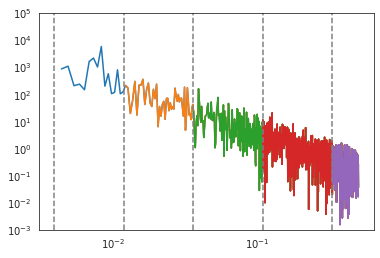

In [16]:
def plot_color_psd(data,n_cut=1,
                   colors=['C9','C8','C7','C6','C5','C4','C3','C2','C1','C0'],
                   title=None,
                   fontsize=12,
                   index=None):
    '''
    Plot the PSD of a time series with different colors
    '''
    x = []                                                     # x is the list of the frequencies where the PSD is cut
    
    l = DBeta(n_cut)                                           # n_cut is the number of cuts
    psd, freq = l.psd(data)                                    # psd is the list of the PSDs, freq is the list of the frequencies
    if index is None:                                          # index is the index of the PSD that is plotted
        betas = DBeta().beta(data).detach().numpy()            # betas is the list of the betas
        index = find_closest_to_mean(betas)                    # index is the index of the PSD that is plotted
    psd, freq = psd[index], freq[index]                        # psd is the PSD that is plotted, freq is the frequencies that is plotted
    
    df = pd.DataFrame()                                        # df is the dataframe that contains the frequencies and the PSDs
    df.insert(0,'freq',freq) 
    df.insert(1,'psd',psd)
   
    for i in range(n_cut): x.append(len(data)**(-(i+1)/n_cut)) # x is the list of the frequencies where the PSD is cut
    for i in reversed(range(n_cut)):                           # i is the index of the cut
        plt.loglog(df['freq'][(df['freq'] > x[i])],df['psd'][(df['freq'] > x[i])])
        plt.axvline(x=x[i],color='gray',linestyle='--',label=(i,x[i]))
        plt.ylim(1e-3,1e5)                                   #Setting the y axis limits
        plt.title(title,fontsize=fontsize) 

def plot_cut_violin(data,n_cut=1, colors=['C0','C1','C2','C3','C4','C5','C6','C7','C8'], beta=0,rotation=45,ax = None):
    l = DBeta(n_cut=n_cut)
    betas_cuted,ticklabels =[], []
    b = l.beta(data).detach().numpy()
    for i in range(n_cut):
        betas_cuted.append(b[:,i])
        ticklabels.append(f'Cut {i+1}')
    sns.violinplot(data=betas_cuted, orient='v',palette=colors,
                   cut=0, inner='quartile', scale='width', width=0.8,
                    linewidth=0, inner_linewidth=1.5,  ax=ax)
    if ax != None: 
        ax.set_xticklabels(ticklabels,rotation=rotation)
        for l in ax.lines:
            l.set_linestyle('--')
            l.set_linewidth(1)
            l.set_color('white')
        for l in ax.lines[1::3]:
            l.set_linestyle(':')
            l.set_linewidth(1.8)
            l.set_color('white')
        

plot_color_psd(data = trainY, n_cut= 5)

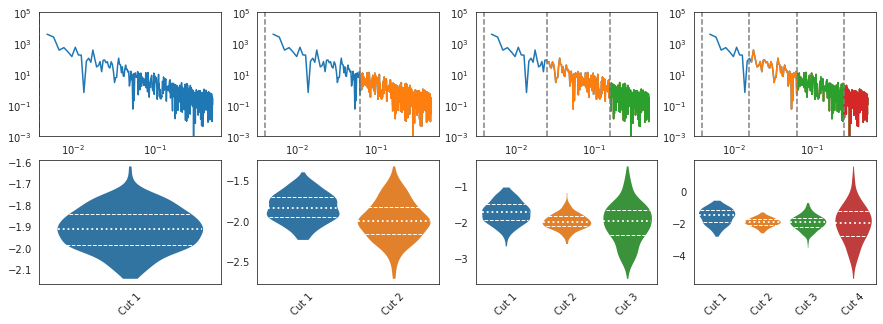

In [18]:
fig = plt.figure(figsize=(15,5))
#gs = GridSpec(3, 3,width_ratios=[3,1,1])#,height_ratios=[1,1,1])
n_cut = 4
for i in range(n_cut):
    ax = fig.add_subplot(2,n_cut,n_cut+i+1)
    plot_cut_violin(trainX, n_cut=i+1, beta=0,ax=ax,rotation=45)    

    ax = fig.add_subplot(2,n_cut,i+1)
    plot_color_psd(data = trainX, n_cut= i+1)
    


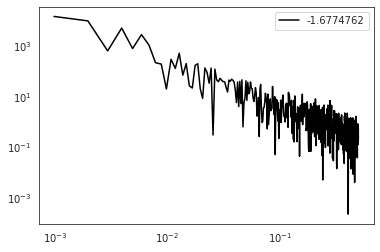

In [232]:
plot_psd_batch(data[3][0],index=None)
plt.legend()


-1.912735 -1.9240044 0.011269571
0.09732851 0.08604289 0.1299085


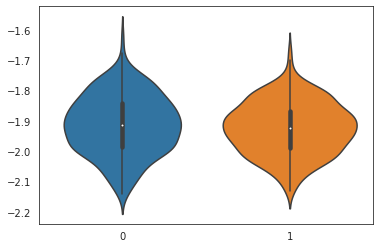

In [245]:
l = DBeta()
a = l.beta(trainX).detach().numpy()
b = l.beta_mono(trainX).detach().numpy()

sns.violinplot(data=[a,b])
print(np.mean(a), np.mean(b), np.mean(a-b))
print(np.std(a), np.std(b), np.std(a-b))